In [ ]:
%%bash
data = cd ../../../datag/blpd0/datax/Voyager_data
ls

bash: line 1: cd: ../../../datag/blpd0/datax/Voyager_data: No such file or directory


blimpy_voyager.ipynb
test.png


In [ ]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)cd
    
    plt.tight_layout()


signal_power was heavily interfering with clustering 602 -> 292


In [ ]:
def processing(file,start,stop):
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]
    columns=['source_name','beam_id','ra_hours' , 'dec_degrees' , 'tstart','signal_frequency', 'signal_beam', 
             'signal_drift_rate', 'signal_snr' , 'signal_power' , 'signal_incoherent_power' ]
    df_new= small_df[columns]

    
    #signal_drift_rate == 0 remove
    # S/R > 20 remove 
    # 
    
    return df_new

    

processing('Summer_Project_RA9_Dec0.pkl', 200500,200550)


,source_name,beam_id,ra_hours,dec_degrees,tstart,signal_frequency,signal_beam,signal_drift_rate,signal_snr,signal_power,signal_incoherent_power
200500,743523336461795840,6243,9.941133,28.856700,60066.885064,1551.308400,0,0.000000,16.236763,2.948859e+12,2.590672e+12
200501,743523336461795840,6243,9.941133,28.856700,60066.885064,1551.306874,0,0.000000,50.895405,8.083028e+12,6.596385e+12
200502,743523336461795840,6249,9.941133,28.856700,60066.885161,1622.840436,0,-47.120487,38.090023,6.816399e+13,4.363362e+13
200503,743333155309867520,6244,9.960400,28.730500,60066.885064,1801.919934,1,0.000000,16.874203,1.458622e+12,1.370342e+12
200504,Incoherent,6242,9.946028,28.826389,60066.884967,1532.604024,5,0.000000,42.901627,5.921884e+12,5.921884e+12
200505,743517082989416704,6246,9.939133,28.729400,60066.885064,1531.468015,3,0.000000,17.471979,3.534250e+12,4.206878e+12
200506,743523336461795840,6243,9.941133,28.856700,60066.885064,1551.304891,0,0.000000,48.917107,7.789972e+12,6.146738e+12
200507,Incoherent,6254,9.946028,28.826389,60066.885161,1622.846822,5,-46.196556,23.353437,4.154916e+13,4.154916e+13
200508,743517082989416704,6246,9.939133,28.729400,60066.885064,1531.461598,3,0.000000,12.080246,2.628983e+12,3.023411e+12
200509,743517082989416704,6240,9.939133,28.729400,60066.884967,1548.822553,3,0.000000,12.587116,2.261894e+12,2.278003e+12


In [1]:
import pandas as pd
import numpy as np

features = [
    'signal_frequency',
    'signal_drift_rate',
    'signal_snr',
    'signal_drift_steps',
    'signal_power'
]

pd.set_option('display.max_columns', None)
df = pd.read_pickle("/datag/users/ctremblay/Summer_Project_RA9_Dec0.pkl")
print(df.columns)
df_without_incoherent = df[(df.source_name != 'Incoherent')]
filtered_column_df = df_without_incoherent[features]
small_df = filtered_column_df[100000:103000]
print(small_df.columns)

Index(['id', 'beam_id', 'observation_id', 'tuning', 'subband_offset',
       'file_uri', 'file_local_enumeration', 'signal_frequency',
       'signal_index', 'signal_drift_steps', 'signal_drift_rate', 'signal_snr',
       'signal_coarse_channel', 'signal_beam', 'signal_num_timesteps',
       'signal_power', 'signal_incoherent_power', 'source_name', 'fch1_mhz',
       'foff_mhz', 'tstart', 'tsamp', 'ra_hours', 'dec_degrees',
       'telescope_id', 'num_timesteps', 'num_channels', 'coarse_channel',
       'start_channel'],
      dtype='object')
Index(['signal_frequency', 'signal_drift_rate', 'signal_snr',
       'signal_drift_steps', 'signal_power'],
      dtype='object')


(3000, 5)
602


<Figure size 1000x600 with 0 Axes>

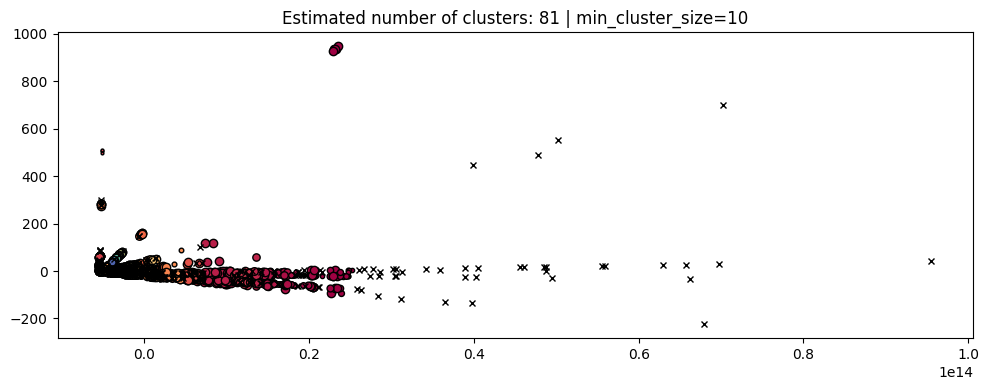

In [4]:
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


%matplotlib inline
plt.figure(figsize=(10,6))

# 1. Prepare full-dimensional numeric data
X = small_df.select_dtypes(include=[np.number]).fillna(0).values
print(X.shape)

# 2. Fit HDBSCAN
clusterer = HDBSCAN(min_cluster_size=10, n_jobs=-1)
clusterer.fit(X)
labels = clusterer.labels_
probabilities = getattr(clusterer, "probabilities_", None)
print(np.count_nonzero(np.where(labels==-1)))

# 3. Project to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

# 4. Plot clusters
plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10})
plt.show()
